In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from sklearn.datasets import make_classification
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestClassifier

from itertools import cycle

from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp
%matplotlib inline

In [2]:
df = pd.read_json('data.json')

In [3]:
df['Fraud'] = ((df['acct_type'] == 'fraudster_event') | (df['acct_type'] == 'fraudster') | \
               (df['acct_type'] == 'locked') | (df['acct_type'] == 'tos_lock') | \
               (df['acct_type'] == 'tos_warn') | (df['acct_type'] == 'fraudster_att'))

In [4]:
df['approx_payout_date'].unique()

array([1266062400, 1296720000, 1296172800, ..., 1361689200, 1361361600,
       1363316400])

In [5]:
## Remove rows with null values in these features
df = df[np.isfinite(df['venue_longitude'])]
df = df[np.isfinite(df['event_published'])]
df = df[np.isfinite(df['org_facebook'])]
df = df[np.isfinite(df['sale_duration'])]
df = df.dropna(subset=['country']) 
df = df.dropna(subset=['delivery_method']) 

In [6]:
#Selecting just the dates
df_copy = df.copy()

datecols = ['approx_payout_date', 'event_created', 'event_end', 'event_start', 'event_published', 'user_created']

convert = lambda x: dt.datetime.fromtimestamp(x)
for i in datecols:
    df_copy[i]=df_copy[i].apply(pd.to_numeric)
    df_copy[i]=df_copy[i].apply(convert)


df_copy['created_date'] = df_copy['event_created'].dt.date
df_copy['started_date'] = df_copy['event_start'].dt.date
# df['published_date'] = df['event_published'].dt.date
df_copy['approx_payout_day'] = df_copy['approx_payout_date'].dt.date
#Creating new column where TRUE if all dates are equal
date_df = df_copy[['Fraud','created_date','started_date']]
date_df['all_equal'] = ((date_df['created_date']==date_df['started_date']))
#(date_df[‘created_date’]==date_df[‘published_date’]) &
# created_started = date_df[date_df['all_equal']==True]
# sum(created_started['Fraud'])/float(len(created_started))


/home/nym2/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [7]:
df['all_equal'] = date_df['all_equal']

In [8]:
df1 = df.copy()

In [9]:
## Keep these column in training data as well as lable columne ['Fraud']
# keep_col = ['approx_payout_date', 'all_equal', 'body_length', 'channels', 'country', 'currency', \
#             'delivery_method', 'event_created', 'event_end', 'event_published', 'event_start', \
#             'fb_published', 'gts', 'has_analytics', 'has_logo', 'listed', \
#             'name_length', 'num_order', 'num_payouts', 'org_facebook', 'org_twitter', \
#             'payout_type', 'sale_duration', 'sale_duration2', 'show_map', 'user_age', \
#             'user_created', 'user_type', 'venue_country', 'venue_latitude', 'venue_longitude', \
#             'venue_state', 'Fraud']

keep_col = ['all_equal', 'body_length', 'channels', 'country', 'currency', \
            'delivery_method', 'event_created', 'event_end', 'event_published', 'event_start', \
            'fb_published', 'gts', 'has_analytics', 'has_logo', 'listed', \
            'name_length', 'num_order', 'num_payouts', 'org_facebook', 'org_twitter', \
            'payout_type', 'sale_duration', 'sale_duration2', 'show_map', 'user_age', \
            'user_created', 'user_type', 'venue_country', 'venue_latitude', 'venue_longitude', \
            'venue_state', 'Fraud']

In [10]:
df1 = df1[keep_col]

In [11]:
dummy_col = ['country', 'currency', 'listed', 'payout_type', 'venue_country', 'venue_state']

In [12]:
dummy_vals = []
### Create dummy columns
for col in dummy_col:
    df1 = pd.concat([df1, pd.get_dummies(df[col])], axis=1)
    dummy_vals.append(list(df1[col].unique()))
    del df1[col]
dummies = dict(zip(dummy_col, dummy_vals))

In [13]:
df2_train, df2_test = train_test_split(df1, test_size = 0.2, random_state = 20)

In [14]:
print "Before training data balance"
print 'Number of True:', len(df2_train[df2_train['Fraud'] == True])
print 'Number of False:', len(df2_train[df2_train['Fraud'] == False])
print 'Percentage of False: ', round(len(df2_train[df2_train['Fraud'] == False]) / \
                                                float(len(df2_train)), 4) * 100, '%'

Before training data balance
Number of True: 842
Number of False: 9628
Percentage of False:  91.96 %


In [15]:
df2_train_True = df2_train[df2_train['Fraud'] == True]

In [16]:
### Balancing traing data
df2_train_False = df2_train[df2_train['Fraud'] == False]
df2_train_False_remove, df2_train_False_keep = train_test_split(df1, test_size = 0.3, random_state = 20)
df2_train_bal = pd.concat((df2_train_True, df2_train_False_keep))

In [17]:
print "After training data balance"
print 'Number of True:', len(df2_train_bal[df2_train_bal['Fraud'] == True])
print 'Number of False:', len(df2_train_bal[df2_train_bal['Fraud'] == False])
print 'Percentage of False: ', round(len(df2_train_bal[df2_train_bal['Fraud'] == False]) / \
                                                float(len(df2_train_bal)), 4) * 100, '%'

After training data balance
Number of True: 1167
Number of False: 3602
Percentage of False:  75.53 %


In [18]:
y_train = df2_train_bal.pop('Fraud')
x_train = df2_train_bal.values
y_test  = df2_test.pop('Fraud')
x_test  = df2_test.values
y_train = y_train.values.reshape(-1,1)
y_test = y_test.values.reshape(-1,1)

In [19]:
# Build a forest and compute the feature importances
forest = ExtraTreesClassifier(n_estimators=250,
                              random_state=0)

forest.fit(x_train, y_train)
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

feature_list = df2_train.columns.values

# Print the feature ranking
print("Feature ranking:")

for f in range(x_train.shape[1]):
    print("%d. feature %d (%f): %s" % (f + 1, indices[f], importances[indices[f]], \
                                       feature_list[f]))

/home/nym2/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Feature ranking:
1. feature 96 (0.080983): all_equal
2. feature 22 (0.071864): body_length
3. feature 17 (0.044361): channels
4. feature 18 (0.039848): delivery_method
5. feature 20 (0.038103): event_created
6. feature 21 (0.036306): event_end
7. feature 16 (0.030696): event_published
8. feature 97 (0.027873): event_start
9. feature 7 (0.027221): fb_published
10. feature 5 (0.026517): gts
11. feature 6 (0.025663): has_analytics
12. feature 3 (0.025327): has_logo
13. feature 4 (0.025036): name_length
14. feature 24 (0.024028): num_order
15. feature 2 (0.023371): num_payouts
16. feature 13 (0.022599): org_facebook
17. feature 12 (0.022199): org_twitter
18. feature 9 (0.022058): sale_duration
19. feature 23 (0.022003): sale_duration2
20. feature 15 (0.021681): show_map
21. feature 98 (0.021667): user_age
22. feature 1 (0.021473): user_created
23. feature 14 (0.020246): user_type
24. feature 0 (0.018179): venue_latitude
25. feature 11 (0.012000): venue_longitude
26. feature 292 (0.011282):

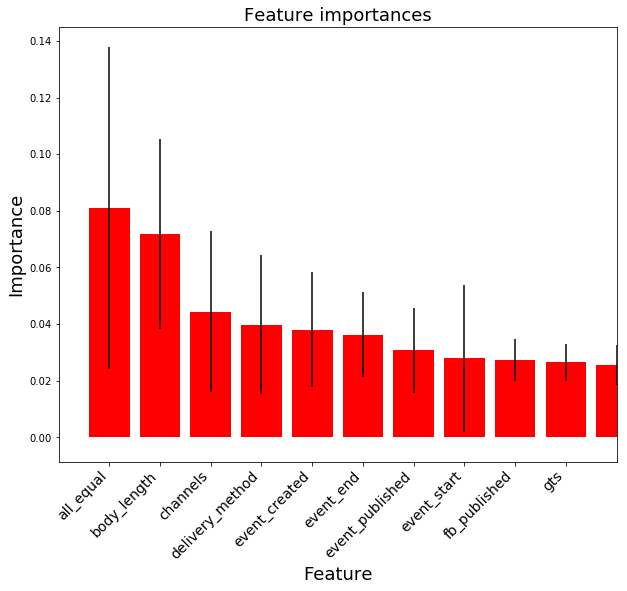

In [20]:
# Plot the feature importances of the forest
mpl_fig = plt.figure(figsize=(10, 8))
ax = mpl_fig.add_subplot(111)
# plt.figure()
ax.set_title("Feature importances", fontsize=18)
ax.bar(range(x_train.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
ax.set_xticks(range(10))
ax.set_xlim([-1, 10])
ax.set_xlabel("Feature", fontsize=18)
ax.set_ylabel("Importance", fontsize=18)
ax.set_xticklabels((feature_list), rotation=45, fontsize=14, ha = 'right')
plt.show()

In [21]:
# Build the RandomForestClassifier again setting the out of bag parameter to be true
rf = RandomForestClassifier(n_estimators=30, oob_score=True)
rf.fit(x_train, y_train)
print "RF accuracy score:", rf.score(x_test, y_test)
print " out of bag score:", rf.oob_score_

/home/nym2/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  app.launch_new_instance()


RF accuracy score: 1.0
 out of bag score: 0.939400293563


In [22]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score
y_predict = rf.predict(x_test)
print precision_score(y_test, y_predict)
print recall_score(y_test, y_predict)

1.0
1.0


In [23]:
print confusion_matrix(y_test, y_predict)

[[2387    0]
 [   0  231]]


/home/nym2/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


After training data balance
Number of True: 1167
Number of False: 3602
Percentage of False:  75.53 %


/home/nym2/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:103: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Feature ranking:
1. feature 96 (0.080983): all_equal
2. feature 22 (0.071864): body_length
3. feature 17 (0.044361): channels
4. feature 18 (0.039848): delivery_method
5. feature 20 (0.038103): event_created
6. feature 21 (0.036306): event_end
7. feature 16 (0.030696): event_published
8. feature 97 (0.027873): event_start
9. feature 7 (0.027221): fb_published
10. feature 5 (0.026517): gts
11. feature 6 (0.025663): has_analytics
12. feature 3 (0.025327): has_logo
13. feature 4 (0.025036): name_length
14. feature 24 (0.024028): num_order
15. feature 2 (0.023371): num_payouts
16. feature 13 (0.022599): org_facebook
17. feature 12 (0.022199): org_twitter
18. feature 9 (0.022058): sale_duration
19. feature 23 (0.022003): sale_duration2
20. feature 15 (0.021681): show_map
21. feature 98 (0.021667): user_age
22. feature 1 (0.021473): user_created
23. feature 14 (0.020246): user_type
24. feature 0 (0.018179): venue_latitude
25. feature 11 (0.012000): venue_longitude
26. feature 292 (0.011282):

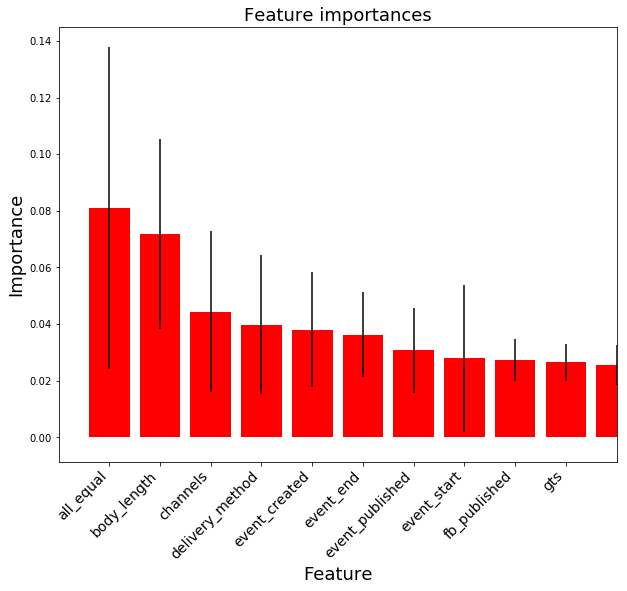

/home/nym2/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


RF accuracy score: 1.0
 out of bag score: 0.937722793038
1.0
1.0
[[2387    0]
 [   0  231]]


In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from sklearn.datasets import make_classification
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, precision_score, recall_score
import cPickle as pickle
import pprint
from itertools import cycle

from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp

df = pd.read_json('data.json')

df['Fraud'] = ((df['acct_type'] == 'fraudster_event') | (df['acct_type'] == 'fraudster') | \
               (df['acct_type'] == 'locked') | (df['acct_type'] == 'tos_lock') | \
               (df['acct_type'] == 'tos_warn') | (df['acct_type'] == 'fraudster_att'))

## Remove rows with null values in these features
df = df[np.isfinite(df['venue_longitude'])]
df = df[np.isfinite(df['event_published'])]
df = df[np.isfinite(df['org_facebook'])]
df = df[np.isfinite(df['sale_duration'])]
df = df.dropna(subset=['country'])
df = df.dropna(subset=['delivery_method'])

#Selecting just the dates
df_copy = df.copy()

datecols = ['approx_payout_date', 'event_created', 'event_end', 'event_start', 'event_published', 'user_created']

convert = lambda x: dt.datetime.fromtimestamp(x)
for i in datecols:
    df_copy[i]=df_copy[i].apply(pd.to_numeric)
    df_copy[i]=df_copy[i].apply(convert)


df_copy['created_date'] = df_copy['event_created'].dt.date
df_copy['started_date'] = df_copy['event_start'].dt.date
# df['published_date'] = df['event_published'].dt.date
df_copy['approx_payout_day'] = df_copy['approx_payout_date'].dt.date
#Creating new column where TRUE if all dates are equal
date_df = df_copy[['Fraud','created_date','started_date']]
date_df['all_equal'] = ((date_df['created_date']==date_df['started_date']))
#(date_df[‘created_date’]==date_df[‘published_date’]) &
# created_started = date_df[date_df['all_equal']==True]
# sum(created_started['Fraud'])/float(len(created_started))
df['all_equal'] = date_df['all_equal']
df1 = df.copy()

## Keep these column in training data as well as lable columne ['Fraud']
# keep_col = ['approx_payout_date', 'all_equal', 'body_length', 'channels', 'country', 'currency', \
#             'delivery_method', 'event_created', 'event_end', 'event_published', 'event_start', \
#             'fb_published', 'gts', 'has_analytics', 'has_logo', 'listed', \
#             'name_length', 'num_order', 'num_payouts', 'org_facebook', 'org_twitter', \
#             'payout_type', 'sale_duration', 'sale_duration2', 'show_map', 'user_age', \
#             'user_created', 'user_type', 'venue_country', 'venue_latitude', 'venue_longitude', \
#             'venue_state', 'Fraud']

keep_col = ['all_equal', 'body_length', 'channels', 'country', 'currency', \
            'delivery_method', 'event_created', 'event_end', 'event_published', 'event_start', \
            'fb_published', 'gts', 'has_analytics', 'has_logo', 'listed', \
            'name_length', 'num_order', 'num_payouts', 'org_facebook', 'org_twitter', \
            'payout_type', 'sale_duration', 'sale_duration2', 'show_map', 'user_age', \
            'user_created', 'user_type', 'venue_country', 'venue_latitude', 'venue_longitude', \
            'venue_state', 'Fraud']
df1 = df1[keep_col]
dummy_col = ['country', 'currency', 'listed', 'payout_type', 'venue_country', 'venue_state']
dummy_vals = []
### Create dummy columns
for col in dummy_col:
    df1 = pd.concat([df1, pd.get_dummies(df[col], prefix = col)], axis=1)
    dummy_vals.append(list(df1[col].unique()))
    df1.pop(col)
dummies = dict(zip(dummy_col, dummy_vals))
df1.shape

df2_train, df2_test = train_test_split(df1, test_size = 0.2, random_state = 20)
df2_train_True = df2_train[df2_train['Fraud'] == True]
### Balancing traing data
df2_train_False = df2_train[df2_train['Fraud'] == False]
df2_train_False_remove, df2_train_False_keep = train_test_split(df1, test_size = 0.3, random_state = 20)
df2_train_bal = pd.concat((df2_train_True, df2_train_False_keep))

print "After training data balance"
print 'Number of True:', len(df2_train_bal[df2_train_bal['Fraud'] == True])
print 'Number of False:', len(df2_train_bal[df2_train_bal['Fraud'] == False])
print 'Percentage of False: ', round(len(df2_train_bal[df2_train_bal['Fraud'] == False]) / \
                                                float(len(df2_train_bal)), 4) * 100, '%'

y_train = df2_train_bal.pop('Fraud')
x_train = df2_train_bal.values
y_test  = df2_test.pop('Fraud')
x_test  = df2_test.values
y_train = y_train.values.reshape(-1,1)
y_test = y_test.values.reshape(-1,1)

# Build a forest and compute the feature importances
forest = ExtraTreesClassifier(n_estimators=250,
                              random_state=0)

forest.fit(x_train, y_train)
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

feature_list = df2_train.columns.values

# Print the feature ranking
print("Feature ranking:")

for f in range(x_train.shape[1]):
    print("%d. feature %d (%f): %s" % (f + 1, indices[f], importances[indices[f]], \
                                       feature_list[f]))

# Plot the feature importances of the forest
mpl_fig = plt.figure(figsize=(10, 8))
ax = mpl_fig.add_subplot(111)
# plt.figure()
ax.set_title("Feature importances", fontsize=18)
ax.bar(range(x_train.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
ax.set_xticks(range(10))
ax.set_xlim([-1, 10])
ax.set_xlabel("Feature", fontsize=18)
ax.set_ylabel("Importance", fontsize=18)
ax.set_xticklabels((feature_list), rotation=45, fontsize=14, ha = 'right')
plt.show()

# Build the RandomForestClassifier again setting the out of bag parameter to be true
rf = RandomForestClassifier(n_estimators=30, oob_score=True)
rf.fit(x_train, y_train)
print "RF accuracy score:", rf.score(x_test, y_test)
print " out of bag score:", rf.oob_score_

y_predict = rf.predict(x_test)
print precision_score(y_test, y_predict)
print recall_score(y_test, y_predict)
print confusion_matrix(y_test, y_predict)

pickle.dump((rf, dummies), open('model.p', 'wb'))


In [6]:
col1 = df.columns
col2 = df2_train_bal.columns

In [7]:
delcols = [col for col in col1 if col not in col2]

In [8]:
delcols

[u'acct_type',
 u'approx_payout_date',
 u'country',
 u'currency',
 u'description',
 u'email_domain',
 u'has_header',
 u'listed',
 u'name',
 u'object_id',
 u'org_desc',
 u'org_name',
 u'payee_name',
 u'payout_type',
 u'previous_payouts',
 u'ticket_types',
 u'venue_address',
 u'venue_country',
 u'venue_name',
 u'venue_state',
 'Fraud']

In [9]:
m = pickle.load(open('model.p','rb'))

In [54]:
print rf.predict_proba(x_test[0])
print y_test[0]

[[ 1.  0.]]
[False]


/home/nym2/anaconda/lib/python2.7/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


In [11]:
m[1]

{'country': [u'US',
  u'FR',
  u'CA',
  u'GB',
  u'',
  u'AU',
  u'ES',
  u'NL',
  u'DE',
  u'NZ',
  u'PK',
  u'AR',
  u'MX',
  u'SG',
  u'TH',
  u'BE',
  u'PH',
  u'CH',
  u'A1',
  u'CI',
  u'IE',
  u'AT',
  u'MA',
  u'ID',
  u'NI',
  u'IT',
  u'VN',
  u'RS',
  u'RO',
  u'NG',
  u'CZ',
  u'PR',
  u'HU',
  u'PT',
  u'AE',
  u'BS',
  u'KH',
  u'JM',
  u'IN',
  u'NA',
  u'HR',
  u'VI',
  u'TJ',
  u'BG',
  u'GH',
  u'GR',
  u'QA',
  u'BB',
  u'CM',
  u'IS',
  u'SE',
  u'DZ',
  u'UY',
  u'FI',
  u'MY',
  u'ZA',
  u'IM',
  u'LB',
  u'CR',
  u'CO',
  u'EC',
  u'JE',
  u'TR'],
 'currency': [u'USD', u'EUR', u'CAD', u'GBP', u'AUD', u'NZD'],
 'listed': [u'y', u'n'],
 'payout_type': [u'', u'CHECK', u'ACH'],
 'venue_country': [u'US',
  u'',
  u'CA',
  u'FR',
  u'GB',
  u'AU',
  u'ES',
  u'NL',
  u'DE',
  u'IE',
  u'NZ',
  u'NO',
  u'AR',
  u'SG',
  u'BE',
  u'PH',
  u'IT',
  u'AT',
  u'MA',
  u'ID',
  u'NI',
  u'VN',
  u'AE',
  u'DO',
  u'PR',
  u'CZ',
  u'DK',
  u'TR',
  u'BS',
  u'HT',
  u'KH',


In [12]:
col1

Index([         u'acct_type', u'approx_payout_date',        u'body_length',
                 u'channels',            u'country',           u'currency',
          u'delivery_method',        u'description',       u'email_domain',
            u'event_created',          u'event_end',    u'event_published',
              u'event_start',       u'fb_published',                u'gts',
            u'has_analytics',         u'has_header',           u'has_logo',
                   u'listed',               u'name',        u'name_length',
                u'num_order',        u'num_payouts',          u'object_id',
                 u'org_desc',       u'org_facebook',           u'org_name',
              u'org_twitter',         u'payee_name',        u'payout_type',
         u'previous_payouts',      u'sale_duration',     u'sale_duration2',
                 u'show_map',       u'ticket_types',           u'user_age',
             u'user_created',          u'user_type',      u'venue_address',
            

In [16]:
sum([len(dummies[col]) for col in dummies])

581

In [17]:
df.shape

(13088, 46)

In [24]:
import cPickle as pickle

In [46]:
cols1 = pickle.load(open('cols.p','rb'))

In [47]:
cols2 = df2_train_bal.columns.values

In [48]:
weird = [col for col in cols2 if col not in cols1]
normal = [col for col in cols1 if col not in cols2]

In [35]:
df2_train_bal.shape

(4769, 606)

In [50]:
len(normal)

581

In [42]:
from collections import Counter

In [43]:
weird = Counter(cols2)

In [44]:
weird.most_common()

[(u'', 4),
 (u'MA', 3),
 (u'DE', 3),
 (u'CO', 3),
 (u'CA', 3),
 (u'IN', 3),
 (u'ID', 3),
 (u'NL', 3),
 (u'AR', 3),
 (u'GB', 2),
 (u'ZA', 2),
 (u'MY', 2),
 (u'MX', 2),
 (u'FR', 2),
 (u'FI', 2),
 (u'SK', 2),
 (u'SG', 2),
 (u'SE', 2),
 (u'VI', 2),
 (u'ES', 2),
 (u'KH', 2),
 (u'DZ', 2),
 (u'QA', 2),
 (u'JM', 2),
 (u'JE', 2),
 (u'PR', 2),
 (u'PT', 2),
 (u'PK', 2),
 (u'PH', 2),
 (u'CM', 2),
 (u'CZ', 2),
 (u'IS', 2),
 (u'IT', 2),
 (u'VN', 2),
 (u'IL', 2),
 (u'IE', 2),
 (u'BE', 2),
 (u'BG', 2),
 (u'BS', 2),
 (u'HR', 2),
 (u'HU', 2),
 (u'UY', 2),
 (u'US', 2),
 (u'AT', 2),
 (u'NI', 2),
 (u'NA', 2),
 (u'NG', 2),
 (u'NZ', 2),
 (u'TR', 2),
 (u'TH', 2),
 (u'AE', 2),
 (u'AU', 2),
 (u'name_length', 1),
 (u'Languedoc-Roussillon', 1),
 (u'Ouest', 1),
 (u'ON', 1),
 (u'West Yorkshire', 1),
 (u'West Berkshire', 1),
 (u'Ad Dawhah', 1),
 (u'TAS', 1),
 (u'Kirklees', 1),
 (u'Swindon', 1),
 (u'event_start', 1),
 (u'County Waterford', 1),
 (u'Gwynd', 1),
 (u'Mersyd', 1),
 (u'GR', 1),
 (u'Stockholms l\xe4n', 1),


<bound method DataFrame.info of       all_equal  body_length  channels  delivery_method  event_created  \
14336     False            0         0              0.0     1360686846   
5845       True            0         5              0.0     1362312370   
2998      False           37        13              0.0     1380873192   
4160      False         8836         6              0.0     1335554497   
8625      False          811         6              0.0     1329222112   
10649     False         2472         4              1.0     1331134800   
6491      False            0         0              0.0     1378238234   
10240     False         3725         8              1.0     1350417949   
11664     False         1759         5              0.0     1334967701   
128       False         1045         0              0.0     1330545234   
7224      False          906         6              0.0     1347212190   
8638      False         1633         0              0.0     1331476773   
7764  